In [2]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

frameset_res = 256
#strNewFramesetName = 'primitives_64_wht'
strFramesetBaseName = 'reflective_primitives'
strFramesetName = strFramesetBaseName + '_' + str(frameset_res)
img_size = 32
batch_size = 128
test_batch_size = 128
#num_frames = 4900
num_frames = 100
#num_frames = None

orig_frameset = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
orig_frameset.Print()
print(orig_frameset.shape())

# Split up into Conditional and RGB Target framesets
framesetRGB = frameset(
    sourceFrameset=orig_frameset, 
    strNewFramesetName=strFramesetBaseName + "RGB", 
    sourceChannels=['Color']
)

framesetRGB.Print()
#framesetRGB[0].visualize()

# #spheresCond.visualize()
# #framesetRGB.visualize()

# Shape of a single frame
print(framesetRGB.shape())

# split spheresRGB into spheresRGB_train, speheresRGB_test

framesetRGB_train, framesetRGB_test = framesetRGB.split_into_train_and_test(0.8)
print(framesetRGB_train.shape())
print(framesetRGB_test.shape())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading frames 1 to 101


frame:   0%|          | 0/100 [00:00<?, ?it/s]

Frameset: reflective_primitives_256, 100 frames with 13 channels JIT enabled
(100, 256, 256, 37)
Frameset: reflective_primitivesRGB, 100 frames with 1 channels JIT enabled
(100, 256, 256, 3)
(80, 256, 256, 3)
(20, 256, 256, 3)


In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Conv VAE
# Only learns the distribution of the target RGB images
# This network doesn't need anything outside of the target images and is entirely unsupervised 

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SpatialViewConvVAE import SpatialViewConvVAE
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.ConvVAETorchSolver import ConvVAETorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
ptu.SetGPUMode(True)

# Set up model
num_rgb, H_rgb, W_rgb, C_rgb = framesetRGB.shape()
latent_dim = 12
batch_size = 20
test_batch_size = 10
view_dim = 7

#print("input dims: %d, %d, %d" % (H_frames, W_frames, C_frames))
print("target dims: %d, %d, %d" % (H_rgb, W_rgb, C_rgb))

modelConvVAE = SpatialViewConvVAE(
    input_shape=(H_rgb, W_rgb, C_rgb),
    latent_dim=latent_dim,
    view_dim=7,
    num_filters = 128,
    num_layers = 6
)

# Test model
# npFrameBuffer = framesetRGB_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())
# print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# modelConvVAE.encoder.forward(torchImageBuffer)

# loss = modelConvVAE.loss_with_frame(framesetRGB_train[0])
# print(loss)

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 100000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
}

# Train on frameset (no minibatching yet)
solver = ConvVAETorchSolver(modelConvVAE, dictSolverParams)
solver.train_frameset_and_plot_losses(
    train_frameset=framesetRGB_train, 
    test_frameset=framesetRGB_test,
    fVerbose=True)

# Sample the network
sampleImages = modelConvVAE.sample(10)
sampleImages[0].visualize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
target dims: 256, 256, 3
3
spatial 256 -> 128 depth 8 -> 16
spatial 128 -> 64 depth 16 -> 32
spatial 64 -> 32 depth 32 -> 64
spatial 32 -> 16 depth 64 -> 128
spatial 16 -> 8 depth 128 -> 256
linear 2048 -> 24


Epoch:   0%|          | 0/100000 [00:00<?, ?it/s]

training on frame:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
import torch

strCheckpoint = "spatialViewConvVAE_checkpoint.tar"

solver.SaveCheckpoint(strCheckpoint, 0, 0)

In [4]:
import torch

strCheckpoint = "spatialViewConvVAE_checkpoint.tar"

solver.LoadCheckpoint(strCheckpoint)

(0, 0)

In [32]:
import torch

solver.train_frameset_and_plot_losses(
    train_frameset=framesetRGB_train, 
    test_frameset=framesetRGB_test,
    fVerbose=True)

Epoch:   0%|          | 0/100000 [00:00<?, ?it/s]

training on frame:   0%|          | 0/20 [00:00<?, ?it/s]

BufferError: 

(-1.775026216888285, 9.144957554275265, 8.389201016429702)


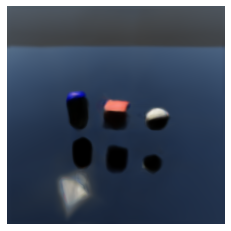

In [30]:
from repos.pyjunk.junktools.CameraView import CameraView
import math

theta = 2.0 * math.pi 
phi = 1.0
radius = 10.0
ptLookAt = (0.0, 4.0, 0.0)

x_pos = radius * math.cos(2.0 * math.pi * (theta)) 
z_pos = radius * math.sin(2.0 * math.pi * (theta))
y_pos = radius * ((phi) * 2.0 - 1.0) * (.6)
norm = math.sqrt(x_pos ** 2 + y_pos ** 2 + z_pos ** 2)
x_pos = (x_pos / norm) * radius + ptLookAt[0]
y_pos = (y_pos / norm) * radius + ptLookAt[1]
z_pos = (z_pos / norm) * radius + ptLookAt[2]

ptPosition = (x_pos, y_pos, z_pos)
print(ptPosition)

camView = CameraView(ptPosition=ptPosition, vLookAt=ptLookAt)
gen_image = modelConvVAE.generate_with_view(camView)
gen_image.visualize()

In [6]:
#!pip install moviepy

from repos.pyjunk.junktools.CameraView import CameraView
import math
from moviepy.editor import ImageSequenceClip
import numpy as np
import time

from tqdm import tqdm_notebook

num_divs_horz = 60
num_divs_vert = 7
radius_start = 1.0
radius_end = 10.0
radius_inc = (radius_start - radius_end) / (num_divs_horz * num_divs_vert)

fps = 12
scale = 1.0
strFilename = "spatial_view_conv_vae.gif"
ptLookAt = (0.0, 4.0, 0.0)

npGifBuffers = []

start_time = time.time()

radius = radius_start
#radius = radius_end

pbar_vert = tqdm_notebook(range(num_divs_vert), desc='vertical divs', leave=False)
for phi in pbar_vert:
    pbar_horz = tqdm_notebook(range(num_divs_horz), desc='horizontal divs', leave=False)
    for theta in pbar_horz:
        x_pos = radius * math.cos(2.0 * math.pi * (theta / num_divs_horz)) 
        z_pos = radius * math.sin(2.0 * math.pi * (theta / num_divs_horz))
        #y_pos = radius * ((phi / num_divs_vert) * 2.0 - 1.0) * (.6)
        y_pos = radius * ((phi / num_divs_vert) * 2.0) * (.6) # no negative
        norm = math.sqrt(x_pos ** 2 + y_pos ** 2 + z_pos ** 2)
        x_pos = (x_pos / norm) * radius + ptLookAt[0]
        y_pos = (y_pos / norm) * radius + ptLookAt[1]
        z_pos = (z_pos / norm) * radius + ptLookAt[2]
        
        ptPosition = (x_pos, y_pos, z_pos)
        camView = CameraView(ptPosition=ptPosition, vLookAt=ptLookAt)
        #camView.Print()

        gen_image = modelConvVAE.generate_with_view(camView)
        #gen_image.visualize()

        #npBuffer = gen_image.GetNumpyBuffer().transpose(2, 0, 1)
        npBuffer = gen_image.GetNumpyBuffer() * 255.0
        #npBuffer = numpy.clip(npBuffer, 0, 255)
        #print(npBuffer.shape)
        npGifBuffers.append(np.array(npBuffer))
        
        radius += radius_inc

end_time = time.time()
num_frames = num_divs_vert * num_divs_horz
time_per_frame = ((end_time - start_time)/num_frames) 
fps = 1./time_per_frame
time_per_frame *= 1000.0 # ms
print("rendered %s frames at %s microseconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

if(fps > 30):
    fps = 30

# make the moviepy clip
clip = ImageSequenceClip(npGifBuffers, fps = fps).resize(scale)
clip.write_gif(strFilename, fps = fps)

vertical divs:   0%|          | 0/7 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

horizontal divs:   0%|          | 0/60 [00:00<?, ?it/s]

rendered 420 frames at 37.22686313447498 microseconds/frame that's 26.86232241453409 frames per second


t:   2%|▏         | 9/420 [00:00<00:05, 79.26it/s, now=None]

MoviePy - Building file spatial_view_conv_vae.gif with imageio.
